# Анализ рекламных источников мобильной игры

**ЦЕЛИ И ХОД ИССЛЕДОВАНИЯ**

**Вводные**\
В игре "xxx" пользователи строят свою космическую программу и пытаются преуспеть в нелёгком деле колонизации галактики.\
Игра уже пользуется популярностью. Пользователи приклекаются в игру из разных рекламных источников.\
Основная монетизация игры только планируется. Предполагается, что в приложении будет происходить показ рекламы на экране с выбором типа объекта для постройки.

**Цели**\
Определить, какой канал привлечения пользователей наиболее выгоден.

**Задачи**\
Для решения вышеуказанной целей мы решим следующие задачи:
- Проведем категоризацию пользователей по каналам - перешел/не перешел на 2 уровень
- Определим каналы, из которых приходят наиболее вовлеченные пользователи (доля пользователей, переходящих на 2й уровень)
- Определим каналы, из которых пришли самые активные пользователи - строящие наибольшее кол-во зданий
- Внутри каждого канала определим соотношение стратегий: кол-во пользователей, завершающих уровень через победу над врагом vs Реализацию проекта
- Определим среднее время прохождения уровня по категориям по каждой из стратегий
- Выясним, как распределены расходы по рекламным источникам
- Выясним, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

## 1 Декомпозиция

1.1 **ПРЕДОБРАБОТКА И ПОДГОТОВКА ДАННЫХ**
1. Первичное ознакомление с данными
2. Проверка на наличие явных и неявных дубликатов
3. Проверка на пропуски
4. Добавление столбца "Способ прохождения 1го уровня (через реализацию проекта/через победу над игроком)"
5. Добавление столбца "Время прохождения 1го уровня"

1.2 **ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ**

ИССЛЕДОВАНИЕ ИСТОЧНИКОВ И ЕГО ВЛИЯНИЯ НА ПОВЕДЕНИЕ ПОЛЬЗОВАТЕЛЯ
1. Проведем категоризацию пользователей по каналам - перешел/не перешел на 2 уровень
2. Определим каналы, из которых приходят наиболее вовлеченные пользователи (доля пользователей, переходящих на 2й уровень)
3. Определим каналы, из которых пришли самые активные пользователи - строящие наибольшее кол-во зданий
4. Внутри каждого канала определим соотношение стратегий: кол-во пользователей, завершающих уровень через победу над врагом vs Реализацию проекта
5. Определим среднее время прохождения уровня по категориям по каждой из стратегий

РЕКЛАМА
1. Выясним, как распределены расходы по рекламным источникам
2. Выясним, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

1.3 **ПРОВЕРКА СТАТИСТИЧЕСКИХ ГИПОТЕЗ**

**Гипотеза №1**: время завершения уровня различается в зависимости способа прохождения

`H0` - среднее время завершения уровня **одинаково** вне зависимости способа прохождения уровня\
`H1` - среднее время завершения уровня **различается** в зависимости способа прохождения уровня

Проведение t-теста

**Гипотеза №2**: пользователи, пришедшие из источника X, более вовлеченены в игру (чаще переходят на следующий уровень), чем пользователи, пришедшие из источника Y

`H0` - доли вовлеченных пользователей, пришедших из источника X и Y **одинаковы**\
`H1` - между долями вовлеченных пользователей, пришедших из источника X и Y, **есть значимая разница**

Проведение z-теста

## 2 Предобработка данных

### 2.1 Ознакомление с данными

In [1]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import math as mth

In [2]:
# сохранием датасеты в переменные
try:
    path = "C://Users//Светлана//Downloads//"
    game_actions = pd.read_csv (path + "game_actions.csv")
    ad_costs = pd.read_csv (path + "ad_costs.csv")
    user_source = pd.read_csv (path + "user_source.csv")
except: 
    game_actions=pd.read_csv("https://code.s3.yandex.net/datasets/game_actions.csv")
    ad_costs=pd.read_csv("https://code.s3.yandex.net/datasets/ad_costs.csv")
    user_source=pd.read_csv("https://code.s3.yandex.net/datasets/user_source.csv")

In [3]:
display (game_actions.head(5))
display (ad_costs.head(5))
display (user_source.head(5))

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


**Ознакомимся с датасетом `game_actions`**

In [4]:
# выведем общую информацию о датасете
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


Изменим тип данных в столбце с датой события, а также добавим столбцец только с датой

In [5]:
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])
game_actions['date'] = game_actions['event_datetime'].astype('datetime64[D]')

In [6]:
game_actions.head(3)

,event_datetime,event,building_type,user_id,project_type,date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04 00:00:01
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04 00:00:03
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04 00:00:16


In [7]:
# узнаем мин и макс дату события
display (game_actions['date'].min())
display (game_actions['date'].max())

Timestamp('2020-05-04 00:00:01')

Timestamp('2020-06-05 12:32:49')

In [8]:
# выведем список уникальных событий
game_actions['event'].unique()

array(['building', 'finished_stage_1', 'project'], dtype=object)

In [9]:
# выведем список уникальных проектов
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

**Ознакомимся с датасетом `ad_costs`**

In [10]:
# выведем общую информацию о датасете
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [11]:
# выведем список уникальных источников
ad_costs['source'].unique()

array(['facebook_ads', 'instagram_new_adverts', 'yandex_direct',
       'youtube_channel_reklama'], dtype=object)

**Ознакомимся с датасетом `user_source`**

In [12]:
# выведем общую информацию о датасете
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [13]:
# выведем список уникальных источников
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

### 2.2 Проверка данных на наличие явных дубликатов

In [14]:
# проверим данные на неявные дубликаты
display (game_actions.duplicated().sum())
display (ad_costs.duplicated().sum())
display (user_source.duplicated().sum())

1

0

0

In [15]:
# в game actions есть дубликат. Выведем его
game_actions[game_actions.duplicated(keep=False)]

,event_datetime,event,building_type,user_id,project_type,date
74890,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN,2020-05-10 18:41:56
74891,2020-05-10 18:41:56,building,research_center,c9af55d2-b0ae-4bb4-b3d5-f32aa9ac03af,NaN,2020-05-10 18:41:56


In [16]:
# удалим дубликат
game_actions=game_actions.drop_duplicates()
display (game_actions.duplicated().sum())

0

Неявные дубликаты в датасетах отсутствуют - мы убедились в этом ранее, выводя список уникальных значений текстовых столбцов

### 2.3 Работа с пропусками

In [17]:
display (game_actions.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135639 entries, 0 to 135639
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_datetime  135639 non-null  datetime64[ns]
 1   event           135639 non-null  object        
 2   building_type   127956 non-null  object        
 3   user_id         135639 non-null  object        
 4   project_type    1866 non-null    object        
 5   date            135639 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 7.2+ MB


None

**Столбец `building_type`**

In [18]:
game_actions[game_actions['building_type'].isna()]

,event_datetime,event,building_type,user_id,project_type,date
6659,2020-05-04 19:47:29,finished_stage_1,NaN,ced7b368-818f-48f6-9461-2346de0892c5,NaN,2020-05-04 19:47:29
13134,2020-05-05 13:22:09,finished_stage_1,NaN,7ef7fc89-2779-46ea-b328-9e5035b83af5,NaN,2020-05-05 13:22:09
15274,2020-05-05 18:54:37,finished_stage_1,NaN,70db22b3-c2f4-43bc-94ea-51c8d2904a29,NaN,2020-05-05 18:54:37
16284,2020-05-05 21:27:29,finished_stage_1,NaN,903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b,NaN,2020-05-05 21:27:29
19650,2020-05-06 06:02:22,finished_stage_1,NaN,58e077ba-feb1-4556-a5a0-d96bd04efa39,NaN,2020-05-06 06:02:22
...,...,...,...,...,...,...
135632,2020-06-04 15:50:38,finished_stage_1,NaN,22cce310-fe10-41a2-941b-9c3d63327fea,NaN,2020-06-04 15:50:38
135633,2020-06-04 17:56:14,finished_stage_1,NaN,d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8,NaN,2020-06-04 17:56:14
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,2020-06-05 02:25:12
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,2020-06-05 12:12:27


Похоже, что пропуски в столбце "building_type" обусловлены логикой устройства и сбора данных: там, где событие "finished_stage_1", нет типа здания. Это логично.\
Проверим, не пропущен ли тип здания там, где событие - "Building".

In [19]:
game_actions.query('event == "building" & building_type.isna()')

,event_datetime,event,building_type,user_id,project_type,date


**Столбец `project_type`**

In [20]:
game_actions[game_actions['project_type'].isna()]

,event_datetime,event,building_type,user_id,project_type,date
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,2020-05-04 00:00:01
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,2020-05-04 00:00:03
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,2020-05-04 00:00:16
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,2020-05-04 00:00:16
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,2020-05-04 00:00:35
...,...,...,...,...,...,...
135635,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,2020-06-05 00:08:06
135636,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,2020-06-05 02:25:12
135637,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,2020-06-05 08:57:52
135638,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,2020-06-05 12:12:27


In [21]:
game_actions.query('project_type.isna() & event == "project"')

,event_datetime,event,building_type,user_id,project_type,date


В пропусках столбца "project_type" тоже прослеживается логика. Тип проекта не указан там, где событие не Project.

### 2.4 Объединение таблиц, добавление столбцов

**Объединим таблицы `game_actions` и `user_source`**

In [22]:
game_actions=game_actions.merge(user_source, how = 'left', left_on='user_id', right_on='user_id')

**Добавим столбец со способом прохождения уровня - `Strategy`**
* Если у пользователя есть событие "Finished stage 1" и **отсутствует событие** "Project" - то `"winner"` (победа над врагом)
* Если у пользователя есть событие "Finished stage 1" и **есть событие** "Project" - то `"project"` (через построение орбитальной станции)

Сначала сгруппируем датасет по игрокам, посчитав кол-во каждого событий

In [23]:
events_by_users=game_actions.pivot_table(index='user_id', columns='event',values='date', aggfunc='count').reset_index()
events_by_users

event,user_id,building,finished_stage_1,project
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,NaN,NaN
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,NaN,NaN
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,NaN,NaN
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,NaN
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,NaN,NaN
...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9.0,1.0,NaN
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16.0,NaN,NaN
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,9.0,1.0,NaN
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,7.0,NaN,NaN


Добавим столбец *Strategy*

Напишем функцию, которая, которая заполнит столбец *Strategy* в соответствии с логикой, описанной выше

In [24]:
def strategy_type (row):
    if (row['finished_stage_1'] == 1) & (row['project'] == 1):
        return 'project'
    if (row['finished_stage_1'] == 1) & (row['project'] != 1):
        return 'winner'
    if (row['finished_stage_1'] != 1) & (row['project'] == 1):
        return 'project but not finished'
events_by_users['strategy'] = events_by_users.apply (strategy_type, axis=1)

Проверим, есть ли такие юзеры, которые реализуют проект, но не нажимают на кнопку "Завершить уровень"

In [26]:
events_by_users[events_by_users['strategy']=='project but not finished']

event,user_id,building,finished_stage_1,project,strategy


Таких юзеров нет. Все, кто реализует проект, завершают уровень

Присоединим в датасету `game_actions` столбец со стратегией игроков

In [27]:
game_actions=game_actions.merge(events_by_users, how = 'left', left_on='user_id', right_on='user_id')

**Столбец с временем прохождения уровня - `middle_time`**

## 3 Исследовательский анализ данных

### 3.1 Узнаем, как распределен трафик по источникам

Построим агрегированную таблицу с кол-вом привлеченных юзеров из каждого источника

In [29]:
# сгруппируем данные по источникам и посчитаем кол-во привлеченных пользователей в каждом
users_by_source=game_actions.groupby('source', as_index=False).agg(users=('user_id', 'nunique'))

# добавим столбец с %, который занимает каждый исчтоник
users_by_source['ratio'] = (users_by_source['users'] / users_by_source['users'].sum()*100).round()

# отсортируем данные по кол-ву юзеров по убыванию
users_by_source = users_by_source.sort_values(by='users', ascending=False)

users_by_source

,source,users,ratio
2,yandex_direct,4817,35.0
1,instagram_new_adverts,3347,25.0
0,facebook_ads,2726,20.0
3,youtube_channel_reklama,2686,20.0


Визуализируем таблицу

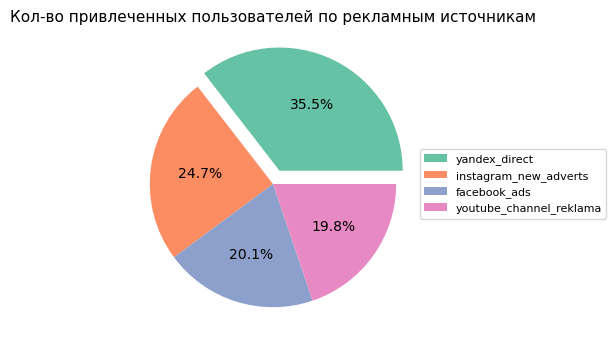

In [30]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 11}

plt.figure(figsize=(5,4))

# построим график, отобразим %, установим цвет, вынесем из "круга" долю самой большой категории
ax=plt.pie(x='users', data=users_by_source,  autopct = '%.1f%%',\
           colors=sns.color_palette('Set2'), explode=[0.12, 0, 0, 0])
plt.title('Кол-во привлеченных пользователей по рекламным источникам', fontdict=font)

# добавим легенду, укажем расположение на графике и размер
plt.legend(labels=users_by_source['source'], loc='right', bbox_to_anchor=(1.3, 0, 0.3, 1),fontsize=8)

plt.show()

**Вывод**\
Больше всего пользователей приходит из Яндекс Директ, далее - Инстаграм, меньше всего - Фейсбук и Ютуб.

### 3.2 Определим каналы, из которых приходят наиболее вовлеченные пользователи (доля пользователей, завершивших Уровень 1)

Посчитаем кол-во пользователей, **не завершивших** 1й уровень по источникам

In [31]:
not_finished_users=game_actions.query('strategy.isna()').groupby(['source'])[['user_id']].nunique()\
                .sort_values(by='user_id', ascending=False).reset_index()
not_finished_users

,source,user_id
0,yandex_direct,2775
1,instagram_new_adverts,1881
2,facebook_ads,1576
3,youtube_channel_reklama,1527


Посчитаем кол-во пользователей, **завершивших** 1й уровень по источникам

In [32]:
finished_users=game_actions.query('strategy.notna()').groupby(['source'])[['user_id']].nunique()\
                .sort_values(by='user_id', ascending=False).reset_index()
finished_users

,source,user_id
0,yandex_direct,2042
1,instagram_new_adverts,1466
2,youtube_channel_reklama,1159
3,facebook_ads,1150


Соединим таблицы

In [33]:
finished_not_users=finished_users.merge(not_finished_users, on='source')
finished_not_users=finished_not_users.set_index('source')
finished_not_users.columns=['завершили уровень', 'не завершили уровень']
finished_not_users

,завершили уровень,не завершили уровень
source,,
yandex_direct,2042,2775
instagram_new_adverts,1466,1881
youtube_channel_reklama,1159,1527
facebook_ads,1150,1576


Визуализируем соотношение

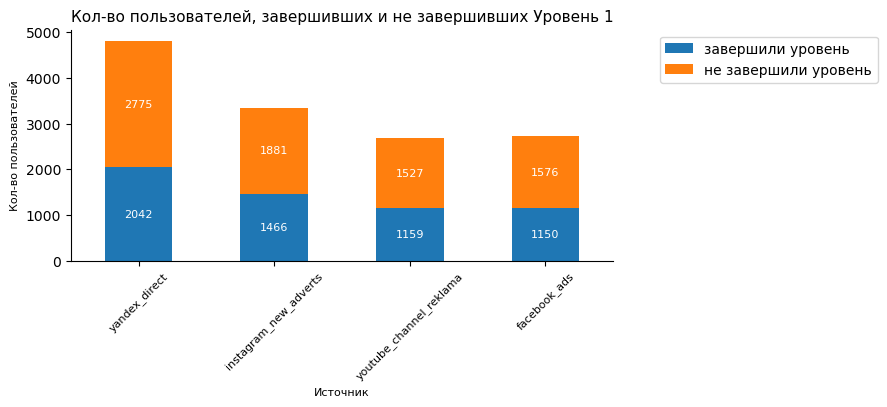

In [34]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 11}

ax=finished_not_users.plot(kind='bar', stacked= True, figsize=(7,3))

plt.title('Кол-во пользователей, завершивших и не завершивших Уровень 1', fontdict=font)

plt.xlabel('Источник', fontsize=8)
plt.ylabel('Кол-во пользователей', fontsize=8)
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0, 0.3, 1),fontsize=10)
for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fontsize=8, color='white')
sns.despine()
plt.show()

Визуализируем соотношение в %

In [35]:
finished_not_users_ratio=finished_not_users.merge(users_by_source, on='source')
finished_not_users_ratio
finished_not_users_ratio['завершили уровень, %']=(finished_not_users_ratio['завершили уровень']/finished_not_users_ratio['users']*100).round(2)
finished_not_users_ratio['не завершили уровень, %']=(finished_not_users_ratio['не завершили уровень']/finished_not_users_ratio['users']*100).round(2)
finished_not_users_ratio=finished_not_users_ratio.drop(['завершили уровень', 'не завершили уровень', 'users', 'ratio'], axis=1) 
finished_not_users_ratio=finished_not_users_ratio.set_index('source')
finished_not_users_ratio

,"завершили уровень, %","не завершили уровень, %"
source,,
yandex_direct,42.39,57.61
instagram_new_adverts,43.80,56.20
youtube_channel_reklama,43.15,56.85
facebook_ads,42.19,57.81


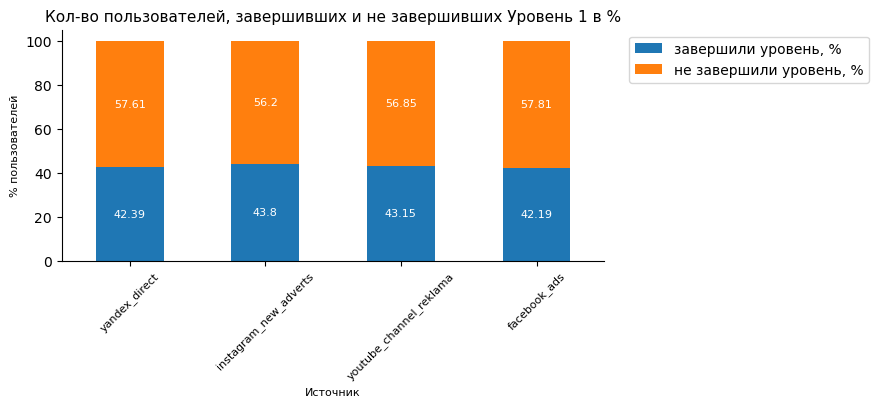

In [36]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 11}

ax=finished_not_users_ratio.plot(kind='bar', stacked= True, figsize=(7,3))

plt.title('Кол-во пользователей, завершивших и не завершивших Уровень 1 в %', fontdict=font)

plt.xlabel('Источник', fontsize=8)
plt.ylabel('% пользователей', fontsize=8)
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0, 0.3, 1),fontsize=10)
for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fontsize=8, color='white')
sns.despine()
plt.show()

**Вывод**\
Завершает уровень в среднем 43% пользователей, это касается всех каналов. Доля завершивших/не завершившых распределена примерно одинаково в каждом из источников.

### 3.3 Внутри каждого канала определим соотношение стратегий: кол-во пользователей, завершающих уровень через победу над врагом vs Реализацию проекта

Посчитаем кол-во пользователей, завершивших уровень через `Победу над врагом`

In [37]:
winners=game_actions.query('strategy == "winner"').groupby(['source'])[['user_id']].nunique()\
                .sort_values(by='user_id', ascending=False).reset_index()
winners

,source,user_id
0,yandex_direct,1422
1,instagram_new_adverts,990
2,youtube_channel_reklama,780
3,facebook_ads,759


Посчитаем кол-во пользователей, завершивших уровень через `Реализацию проекта`

In [38]:
project=game_actions.query('strategy == "project"').groupby(['source'])[['user_id']].nunique()\
                .sort_values(by='user_id', ascending=False).reset_index()
project

,source,user_id
0,yandex_direct,620
1,instagram_new_adverts,476
2,facebook_ads,391
3,youtube_channel_reklama,379


Соединим таблицы

In [39]:
strategy_by_users=winners.merge(project, on='source')
strategy_by_users=strategy_by_users.set_index('source')
strategy_by_users.columns=['победа над врагом', 'проект']
strategy_by_users

,победа над врагом,проект
source,,
yandex_direct,1422,620
instagram_new_adverts,990,476
youtube_channel_reklama,780,379
facebook_ads,759,391


Визуализируем соотношение

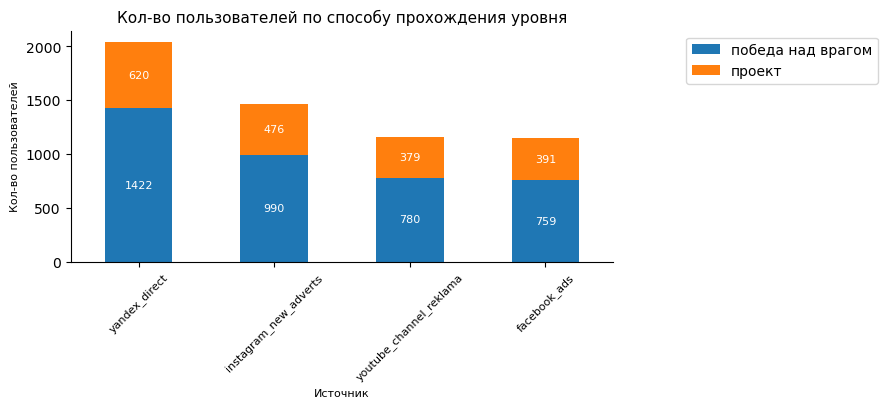

In [40]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 11}

ax=strategy_by_users.plot(kind='bar', stacked= True, figsize=(7,3))

plt.title('Кол-во пользователей по способу прохождения уровня', fontdict=font)

plt.xlabel('Источник', fontsize=8)
plt.ylabel('Кол-во пользователей', fontsize=8)
plt.xticks(rotation=45)
plt.xticks(fontsize=8)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 0, 0.3, 1),fontsize=10)
for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fontsize=8, color='white')
sns.despine()

**Вывод**\
Чаще всего пользователи завершают уровень с помощью "Победы над врагом".\
Если смотреть в процентном соотношении, то все-таки пользователи, пришедшие из Яндекс, делают это чуть чаще.

### 3.4 Определим каналы, из которых пришли самые активные пользователи (строящие наибольшее кол-во зданий)

Добавим с таблицу `events_by_users` данные источника

In [41]:
events_by_users=events_by_users.merge(user_source, how = 'left', left_on='user_id', right_on='user_id')
events_by_users

,user_id,building,finished_stage_1,project,strategy,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,13.0,NaN,NaN,None,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,9.0,NaN,NaN,None,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,4.0,NaN,NaN,None,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,8.0,1.0,NaN,winner,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,12.0,NaN,NaN,None,facebook_ads
...,...,...,...,...,...,...
13571,ffef4fed-164c-40e1-bde1-3980f76d0fb5,9.0,1.0,NaN,winner,instagram_new_adverts
13572,fffab3da-da0e-4e30-ae62-10d0a2e24a4e,16.0,NaN,NaN,None,facebook_ads
13573,fffb626c-5ab6-47c9-8113-2062a2f18494,9.0,1.0,NaN,winner,yandex_direct
13574,ffff194a-56b7-4c12-860d-3485242ae7f5,7.0,NaN,NaN,None,instagram_new_adverts


Посчитаем среднее кол-во зданий на каждого игрока

In [42]:
active_users=events_by_users.groupby(['source'])[['building']].mean().round(2)\
                .sort_values(by='building', ascending=False).reset_index()

active_users

,source,building
0,facebook_ads,9.59
1,instagram_new_adverts,9.51
2,yandex_direct,9.35
3,youtube_channel_reklama,9.30


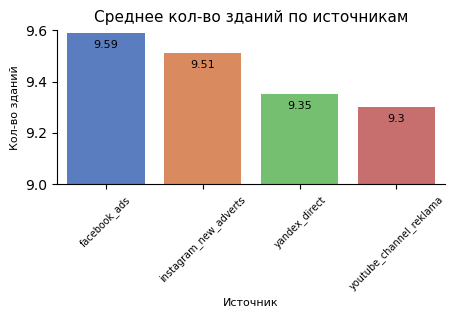

In [43]:
# зададим параметры шрифта для заголовка
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 11}
# зададим цветовой стиль для всех дальнейших графиков matplotlib
sns.set_palette('muted')

# зададим размер графика
plt.figure(figsize=(5,2))

# построим график
ax=sns.barplot(x='source', y='building', data=active_users)

# зададим название графика и шрифт
plt.title('Среднее кол-во зданий по источникам', fontdict=font)

# зададим названия осей и размер шрифта
plt.xlabel('Источник', fontsize=8)
plt.ylabel('Кол-во зданий', fontsize=8)
plt.ylim(9, 9.6)

# зададим направление и размер для подписей столбцов
plt.xticks(rotation=45, fontsize=7)

# добавим аннотацию к столбцам, зададим размер и положение
ax.bar_label(ax.containers[0], label_type='edge',fontsize=8, padding=-12)

# оставим только ось x и y, без контура графика
sns.despine()

# выведем график
plt.show()

Визуализируем среднее кол-во зданий с помощью ящика с усами

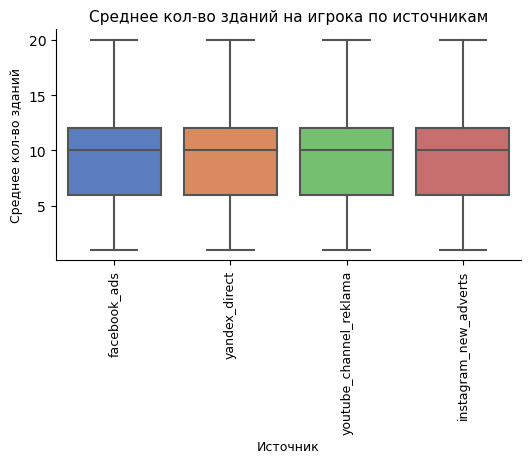

In [44]:
plt.figure(figsize=(6,3))
sns.boxplot(x='source', y='building', data=events_by_users)
plt.title('Среднее кол-во зданий на игрока по источникам', fontdict=font)
plt.xlabel('Источник', fontsize=9)
plt.ylabel('Среднее кол-во зданий', fontsize=9)
plt.xticks(rotation=90, fontsize=9)
sns.despine()

**Вывод**\
Среднее кол-во зданий по источникам отличается не сильно.\
Но самые активные пользователи - из источника Facebook Ads. Наименее активные - Youtube.

### 3.5 Определим, какая категория игроков строит больше зданий

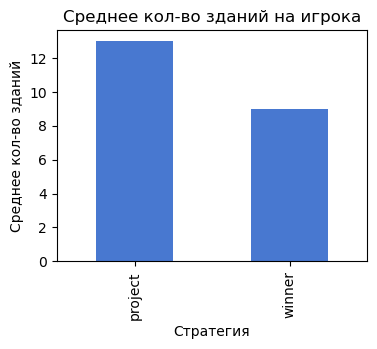

In [45]:
buildings_by_strategy=events_by_users.groupby(['strategy'])[['building']].mean().round()\
                .sort_values(by='building', ascending=False)
buildings_by_strategy.plot(kind='bar',title='Среднее кол-во зданий на игрока', figsize=(4,3), legend=False)
plt.xlabel('Стратегия')
plt.ylabel('Среднее кол-во зданий');

**Вывод**\
Игроки, которые завершают уровень через реализацию проекта, наиболее активны и в среднем строят 13 зданий.\
Игроки, завершающие уровень через победу над игроком, - около 9 зданий.\
Эти данные пригодятся для дальнейшего принятия решения по монетизации.

### 3.6 Выясним, как распределены расходы по рекламным источникам

Построим агрегированную таблицу с суммой расходов на каждый источник привлечения пользователя

In [46]:
# сгруппируем данные по источникам и посчитаем кол-во привлеченных пользователей в каждом
costs=ad_costs.groupby('source', as_index=False).agg(expenses=('cost', 'sum')).round(1)

# добавим столбец с %, который занимает каждый исчтоник
costs['ratio'] = (costs['expenses'] / costs['expenses'].sum()*100).round(1)

# отсортируем данные по кол-ву юзеров по убыванию
costs = costs.sort_values(by='expenses', ascending=False)

costs

,source,expenses,ratio
2,yandex_direct,2233.1,29.4
1,instagram_new_adverts,2161.4,28.4
0,facebook_ads,2140.9,28.2
3,youtube_channel_reklama,1068.1,14.0


Визуализируем таблицу

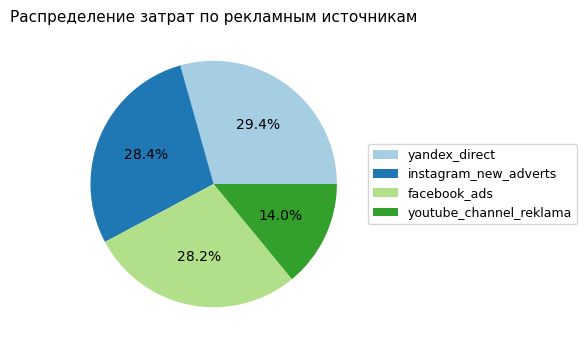

In [47]:
font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 11}

plt.figure(figsize=(5,4))

# построим график, отобразим %, установим цвет, вынесем из "круга" долю самой большой категории
ax=plt.pie(x='expenses', data=costs,  autopct = '%.1f%%',\
           colors=sns.color_palette('Paired'))
plt.title('Распределение затрат по рекламным источникам', fontdict=font)

# добавим легенду, укажем расположение на графике и размер
plt.legend(labels=costs['source'], loc='right', bbox_to_anchor=(1.4, 0, 0.3, 1),fontsize=9)

plt.show()

**Вывод**\
Больше всего средств вкладывается в рекламу Яндекс Директ.\
Расходы на Инстаграм и Фейсбук распределены примерно равномерно.\
Меньше всего вкладывается в Ютуб - примерно в 2 раза меньше, чем в остальные источники.

### 3.7 Выясним, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [48]:
users_by_source

,source,users,ratio
2,yandex_direct,4817,35.0
1,instagram_new_adverts,3347,25.0
0,facebook_ads,2726,20.0
3,youtube_channel_reklama,2686,20.0


In [49]:
costs

,source,expenses,ratio
2,yandex_direct,2233.1,29.4
1,instagram_new_adverts,2161.4,28.4
0,facebook_ads,2140.9,28.2
3,youtube_channel_reklama,1068.1,14.0


Объединим таблицы с кол-вом привлеченных пользователей и затратами по источникам

In [50]:
cac=users_by_source.merge(costs, on='source').drop(['ratio_x', 'ratio_y'], axis=1) 
cac['cac']=(cac['expenses']/cac['users']).round(2)
cac=cac.sort_values(by='cac',ascending=False).style.background_gradient(axis=0, cmap='RdYlGn')
cac

,source,users,expenses,cac
2,facebook_ads,2726,2140.900000,0.790000
1,instagram_new_adverts,3347,2161.400000,0.650000
0,yandex_direct,4817,2233.100000,0.460000
3,youtube_channel_reklama,2686,1068.100000,0.400000


**Вывод**\
Самая высокая стоимость за привлеченного пользователя - по каналу Фейсбук.\
Самая низкая - по каналу Ютуб.

## 4 Проверка статистических гипотез

**Гипотеза №1**: время завершения уровня различается в зависимости способа прохождения

`H0` - среднее время завершения уровня **одинаково** вне зависимости способа прохождения уровня\
`H1` - среднее время завершения уровня **различается** в зависимости способа прохождения уровня

Подготовим таблицу - рассчитаем среднее время прохождения уровня для каждого игрока

In [51]:
average_time=game_actions.query('strategy.notna()').groupby(['user_id', 'source', 'strategy']) .agg({'date':['min','max']}) \
                .sort_values(by='user_id', ascending=False).reset_index()
average_time.columns=['user_id', 'source', 'strategy', 'min_date', 'max_date']
average_time['level_time']=average_time['max_date']-average_time['min_date']
average_time

,user_id,source,strategy,min_date,max_date,level_time
0,ffff69cc-fec1-4fd3-9f98-93be1112a6b8,facebook_ads,project,2020-05-08 06:57:30,2020-05-25 14:05:51,17 days 07:08:21
1,fffb626c-5ab6-47c9-8113-2062a2f18494,yandex_direct,winner,2020-05-04 02:05:09,2020-05-12 13:01:52,8 days 10:56:43
2,ffef4fed-164c-40e1-bde1-3980f76d0fb5,instagram_new_adverts,winner,2020-05-04 01:58:59,2020-05-11 22:15:54,7 days 20:16:55
3,ffe810f4-1a1f-464b-924d-6f120b0cb8df,youtube_channel_reklama,winner,2020-05-04 17:46:05,2020-05-18 02:03:36,13 days 08:17:31
4,ffd002f3-3545-423e-8dba-0c6a2d48a3aa,yandex_direct,winner,2020-05-06 06:34:18,2020-05-19 04:03:24,12 days 21:29:06
...,...,...,...,...,...,...
5812,0056c007-c082-43cc-bdef-afc49bca4cb9,instagram_new_adverts,winner,2020-05-10 11:49:47,2020-05-16 13:48:39,6 days 01:58:52
5813,00464e5e-28ed-4be6-bf44-517ef7b3937b,yandex_direct,winner,2020-05-04 08:35:29,2020-05-15 16:02:01,11 days 07:26:32
5814,004074f8-251a-4776-922c-8348dca1a2f6,facebook_ads,winner,2020-05-04 01:07:35,2020-05-16 19:57:40,12 days 18:50:05
5815,003ee7e8-6356-4286-a715-62f22a18d2a1,instagram_new_adverts,winner,2020-05-05 08:31:04,2020-05-17 21:47:49,12 days 13:16:45


In [52]:
# переведем столбец со среднем временем прохождения в нужный формат
average_time['level_time']=average_time['level_time'].astype('timedelta64[D]')

Подготовим выборки для проведения теста

In [53]:
winners_level_time=average_time.query('strategy=="winner"')['level_time']
project_level_time=average_time.query('strategy=="project"')['level_time']

Проверим, как распределены выборки

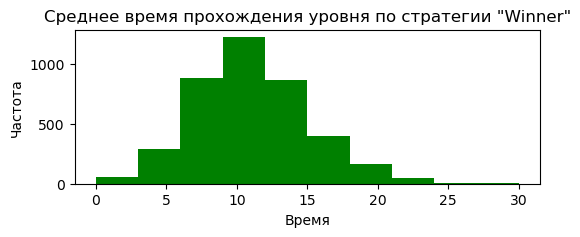

In [54]:
ax=winners_level_time.plot(kind='hist',title='Среднее время прохождения уровня по стратегии "Winner"',color='Green', figsize=(6,2))
plt.xlabel('Время')
plt.ylabel('Частота');

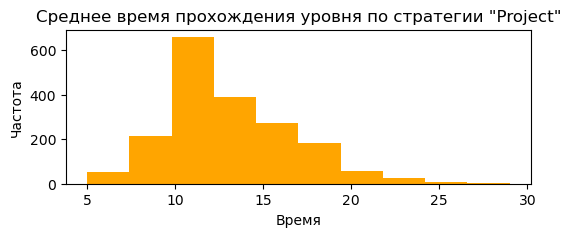

In [55]:
project_level_time.plot(kind='hist',title='Среднее время прохождения уровня по стратегии "Project"',color='Orange', figsize=(6,2))
plt.xlabel('Время')
plt.ylabel('Частота');

Поскольку мы будем проверять гипотезу о равенстве средних двух ген совокупностей, и дисперсии двух выборок распределены нормально, для проведения теста выберем метод - t-критерий Стьюдента

In [56]:
# зададим уровень статистической значимости 
alpha = .05

# для проверки гипотезы о равенстве двух ген совокупностей используем метод st.ttest_ind
results = st.ttest_ind (winners_level_time, project_level_time)

# выведем значение p-value на экран
print("Среднее время завершения уровня методом Winner:", winners_level_time.mean())
print("Среднее время завершения уровня методом Project:", project_level_time.mean())
print("p-value =", results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу - среднее время завершения уровня различается в зависимости способа прохождения уровня")
else:
    print("Не получилось отвергнуть нулевую гипотезу - среднее время завершения уровня одинаково вне зависимости способа прохождения уровня")

Среднее время завершения уровня методом Winner: 10.606175651733738
Среднее время завершения уровня методом Project: 12.963022508038586
p-value = 1.8882835392369192e-97
Отвергаем нулевую гипотезу - среднее время завершения уровня различается в зависимости способа прохождения уровня


**Вывод**\
Как показывает тест, способ прохождения уровня влияет на среднее время его прохождения.\
Среднее время прохождения уровня через реализацию проекта - 13,4 дней.\
Среднее время прохождения уровня через победу над игроком - 11,05 дней.\
Эта статистически значимое различие.

**Гипотеза №2**: пользователи, пришедшие из источника Yandex Direct, более вовлеченены в игру (чаще завершают уровень 1 и переходят на следующий уровень), чем пользователи, пришедшие из источника Youtube Reklama

`H0` - доля вовлеченных пользователей, пришедших из источника Яндекс и Ютуб, **одинаковы**\
`H1` - между долей вовлеченных пользователей, пришедших из источника Яндекс и Ютуб, **есть значимая разница**

В рамках теста мы будем проверять гипотезу о равенстве долей, для проведения теста будем использовать z-критерий Фишера.

Выведем таблицы, данные из которых будем использовать для проведения теста

In [57]:
display (users_by_source)
display (finished_not_users)

,source,users,ratio
2,yandex_direct,4817,35.0
1,instagram_new_adverts,3347,25.0
0,facebook_ads,2726,20.0
3,youtube_channel_reklama,2686,20.0


,завершили уровень,не завершили уровень
source,,
yandex_direct,2042,2775
instagram_new_adverts,1466,1881
youtube_channel_reklama,1159,1527
facebook_ads,1150,1576


In [58]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([2042, 1159])
trials = np.array([4817, 2686])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-value: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу - между долей вовлеченных пользователей, пришедших из источника Яндекс и Ютуб, есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу - доли вовлеченных пользователей, пришедших из источника Яндекс и Ютуб, одинаковы') 

p-value:  0.5244230207169549
Не получилось отвергнуть нулевую гипотезу - доли вовлеченных пользователей, пришедших из источника Яндекс и Ютуб, одинаковы


**Вывод**\
Как показывает тест, мы не можем утверждать, что пользователи, пришедшие из канала Ютуб, завершают уровень чаще, чем пользователи, пришедшие из канала Яндекс.\
Статистически значимого различия между долей вовлеченных пользователей этих двух источников нет.

# Общий вывод

По итогам анализа, мы выяснили, что на данный момент пользователи игры "Космические братья" привлекаются из 4 источников.\
Разберем каналы детально.
* **Фейсбук** - бюджет на рекламу один их самых высоких - 28%, доля пользователей - 20%, `самая высокая САС - 0.79`. `Среднее кол-во зданий на пользователя - 9.59`.
* **Инстаграм** - бюджет на рекламу один их самых высоких - 28%, доля пользователей - 24.7%, САС - 0.65. Среднее `кол-во зданий на пользователя - 9.51`.
* **Яндекс** - на Яндекс тратится бОльшая часть бюджета (29%), из этого канала приходит наибольшая часть пользователя (35%), САС одна из самых низких (0.46, `кол-во зданий на пользователя - 9.35`.
* **Ютуб** - на рекламу тратится меньшая часть бюджета (14%), доля пользователей - 19.8%, `самая низкая САС - 0.40`. `Среднее кол-во зданий на пользователя - 9.3`.

На текущий момент больше всего средств вкладывается в канал **Яндекс**, и на мой взгляд, это оправдано: средняя стоимость привлечения пользователя ниже на целых 40%, чем, например, стоимость привлечения с Фейсбука, а активность игроков почти не отличается (да, в среднем пользователь строит 9.35 зданий за 1 уровень, это один из низких показателей, но это всего на 2% меньше, чем строит пользователь Фейсбука - самый активный пользователь). `Я бы рекомендовала продолжить вкладывать в данный канал. Он один из самых эффективных`.

**Ютуб**, на мой взгляд, недооцененный и наиболее перспективный из всех канал. Во-первых - самый низкий САС, на целых 49% ниже, чем Фейсбук. При этом активность игроков данного канала также почти идентична (да, в среднем пользователь строит 9.3 зданий за 1 уровень, и это самый низкий показатель, но это всего на 3% меньше, чем строит пользователь Фейсбука - самый активный пользователь). При комбинации факторов: всего на 3% меньше построек, но на 49% ниже САС, я бы рекомендовала обратить внимание на этот канал и перераспределить часть бюджета в его пользу. `Данный канал, на мой взгляд, самый эффективный`.

**Инстаграм** и **Фейсбук** - самые дорогостоящие каналы. Да, его пользователи в среднем чуть активнее, чем пользователи из канала Яндекс и Ютуб, но принимая во внимание тот фактор, что стоимость привлечения пользователя примерно на 50% дороже, `я бы рекомендовала сократить объем вложений в данные каналы`.


Рекомендации о приоретизации источников я сделала на основании нескольких факторов - активности пользователей данных каналов, и стоимости их привлечения. Показатель вовлеченности пользователей в финальном выводе я не упоминаю, так как мы выяснили ранее, что доля завершающих Уровень 1 игроков по всем каналам примерно одинаковая - 42-44%.